In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import crypten
from crypten import mpc
import crypten.communicator as comm


from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

from collections import defaultdict
import os

os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
df_nn = pd.read_csv("card_transdata.csv")

train_transactions, test_transactions = train_test_split(df_nn, test_size=0.2, random_state=42)

X_train_transactions = train_transactions.drop(columns=["fraud"])
y_train_transactions = torch.from_numpy(train_transactions.fraud.values).flatten(0)[:10000]
X_test_transactions = test_transactions.drop(columns=["fraud"])
y_test_transactions = torch.from_numpy(test_transactions.fraud.values).flatten(0)

scaler = StandardScaler()
X_train_transactions = torch.from_numpy(pd.DataFrame(scaler.fit_transform(X_train_transactions), columns=X_train_transactions.columns, index=X_train_transactions.index).values)
X_test_transactions = torch.from_numpy(pd.DataFrame(scaler.transform(X_test_transactions), columns=X_test_transactions.columns, index=X_test_transactions.index).values)



print(f"X_train_transactions has shape: {X_train_transactions.shape}")
print(f"y_train_transactions has shape: {y_train_transactions.shape}")
print(f"X_test_transactions has shape: {X_test_transactions.shape}")
print(f"y_test_transactions has shape: {y_test_transactions.shape}")

print(y_train_transactions)




X_train_transactions has shape: torch.Size([800000, 7])
y_train_transactions has shape: torch.Size([10000])
X_test_transactions has shape: torch.Size([200000, 7])
y_test_transactions has shape: torch.Size([200000])
tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)


In [3]:
class CryptenFraudDetectionModel(crypten.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CryptenFraudDetectionModel, self).__init__()
        self.fc1 = crypten.nn.Linear(input_size, hidden_size)
        self.relu = crypten.nn.ReLU()
        self.dropout = crypten.nn.Dropout(0.5)
        self.fc2 = crypten.nn.Linear(hidden_size, num_classes)
        self.sigmoid = crypten.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

input_size = 7
hidden_size = 64
num_classes = 1
model = CryptenFraudDetectionModel(input_size, hidden_size, num_classes)

In [4]:
crypten.init()
torch.set_num_threads(1)

In [5]:
bank1 = 0
bank2 = 1
bank3 = 2
bank4 = 3

# Specify file locations to save data for each bank
filenames = {
    "X_samples_bank1": "data/X_samples_bank1.pth",
    "X_samples_bank2": "data/X_samples_bank2.pth",
    "X_samples_bank3": "data/X_samples_bank3.pth",
    "X_samples_bank4": "data/X_samples_bank4.pth",
    "y_samples_bank1": "data/y_samples_bank1.pth",
    "y_samples_bank2": "data/y_samples_bank2.pth",
    "y_samples_bank3": "data/y_samples_bank3.pth",
    "y_samples_bank4": "data/y_samples_bank4.pth",
}




@mpc.run_multiprocess(world_size=4)
def save_all_data():   
    # Save split dataset for the 4 banks
    X_samples_bank1 = X_train_transactions[:2500]
    X_samples_bank2 = X_train_transactions[2500:5000]
    X_samples_bank3 = X_train_transactions[5000:7500]
    X_samples_bank4 = X_train_transactions[7500:10000]
    crypten.save_from_party(X_samples_bank1, filenames["X_samples_bank1"],src = bank1)
    crypten.save_from_party(X_samples_bank2, filenames["X_samples_bank2"],src = bank2)
    crypten.save_from_party(X_samples_bank3, filenames["X_samples_bank3"],src = bank3)
    crypten.save_from_party(X_samples_bank4, filenames["X_samples_bank4"],src = bank4)

    y_samples_bank1 = y_train_transactions[:2500]
    y_samples_bank2 = y_train_transactions[2500:5000]
    y_samples_bank3 = y_train_transactions[5000:7500]
    y_samples_bank4 = y_train_transactions[7500:10000]
    crypten.save_from_party(y_samples_bank1, filenames["y_samples_bank1"],src = bank1)
    crypten.save_from_party(y_samples_bank2, filenames["y_samples_bank2"],src = bank2)
    crypten.save_from_party(y_samples_bank3, filenames["y_samples_bank3"],src = bank3)
    crypten.save_from_party(y_samples_bank4, filenames["y_samples_bank4"],src = bank4)
    
    
save_all_data()


[None, None, None, None]

In [6]:
@mpc.run_multiprocess(world_size=4)
def encrypted_training():
    # Load data:
    x_bank1_enc = crypten.load_from_party(filenames['X_samples_bank1'], src=bank1)
    x_bank2_enc = crypten.load_from_party(filenames['X_samples_bank2'], src=bank2)
    x_bank3_enc = crypten.load_from_party(filenames['X_samples_bank3'], src=bank3)
    x_bank4_enc = crypten.load_from_party(filenames['X_samples_bank4'], src=bank4)

    y_bank1_enc = crypten.load_from_party(filenames['y_samples_bank1'], src=bank1).get_plain_text()
    y_bank2_enc = crypten.load_from_party(filenames['y_samples_bank2'], src=bank2).get_plain_text()
    y_bank3_enc = crypten.load_from_party(filenames['y_samples_bank3'], src=bank3).get_plain_text()
    y_bank4_enc = crypten.load_from_party(filenames['y_samples_bank4'], src=bank4).get_plain_text()
    model.encrypt()
    # Set train mode
    model.train()
    
    hist = defaultdict(list)
    # Combine the feature sets: identical to Tutorial 3
    x_combined_enc = crypten.cat([x_bank1_enc, x_bank2_enc, x_bank3_enc, x_bank4_enc], dim=0)
    y_combined = torch.cat([y_bank1_enc, y_bank2_enc, y_bank3_enc, y_bank4_enc], dim=0)
    # print(y_combined)
    crypten.print(x_combined_enc.size())
    crypten.print(y_combined.size())

    loss = crypten.nn.loss.BCELoss()
    rank = comm.get().get_rank()

    # Define training parameters
    learning_rate = 0.005
    num_epochs = 100
    batch_size = 1
    num_batches = x_combined_enc.size(0) // batch_size


    label_eye = torch.eye(2)
    
    for i in range(num_epochs):   
    
    # for batch in range(num_batches):
        # define the start and end of the training mini-batch
        # start, end = batch * batch_size, (batch + 1) * batch_size
                                
        # construct CrypTensors out of training examples / labels
        x_train = x_combined_enc
        x_train.requires_grad = True

        y_train = crypten.cryptensor(y_combined, requires_grad=True)

        # perform forward pass:
        output = model(x_train)
        loss_value = loss(output, y_train.unsqueeze(1))
        
        # set gradients to "zero" 
        model.zero_grad()

        # perform backward pass: 
        loss_value.backward()

        # update parameters
        model.update_parameters(learning_rate)
        
        # Print progress every batch:
        batch_loss = loss_value.get_plain_text()
        crypten.print(f"\tEpoch {i} of {num_batches} Loss {batch_loss.item():.4f}")
        if i % 2 == 0:
            f2_score = fbeta_score(np.where(output.get_plain_text() > 0.5, 1, 0), y_train.get_plain_text(), beta=0.5)
            crypten.print(f"\tEpoch {(i)} of {num_batches} f2 score {f2_score:.4f}")
            hist["train_cost"].append(batch_loss.item())
            hist["train_f2"].append(f2_score)
    return hist

hist = encrypted_training()

torch.Size([10000, 7])
torch.Size([10000])
torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])
torch.Size([10000, 1])


torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])
torch.Size([10000, 1])


	Epoch 0 of 10000 Loss 0.7951
	Epoch 0 of 10000 f2 score 0.2899
torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])



torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])



	Epoch 1 of 10000 Loss 0.7896
torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])



torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])



	Epoch 2 of 10000 Loss 0.7848
	Epoch 2 of 10000 f2 score 0.2760
torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])



torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])



	Epoch 3 of 10000 Loss 0.7811
torch.Size([10000, 1])torch.Size(

KeyboardInterrupt: 

torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])



torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])
torch.Size([10000, 1])


	Epoch 10 of 10000 Loss 0.7484
	Epoch 10 of 10000 f2 score 0.2632
torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])



torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])



	Epoch 11 of 10000 Loss 0.7472
torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])



torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])



	Epoch 12 of 10000 Loss 0.7398
	Epoch 12 of 10000 f2 score 0.2672
torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])torch.Size([10000, 1])



torch.Size([10000, 1])torch.Size([10000, 1])
torch.Size([10000, 1])torch.Size([10000, 1])


	Epoch 13 of 10000 Loss 0.7374


In [ ]:
def plot_validation_curve(data, ax=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_title("Validation Curve")
        ax.set_ylabel("Cost")
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel("Epochs")
    ax.plot(data)


def plot_validation_curves(hist, ylim=None):
    fig, ax = plt.subplots(ncols=2, figsize=(16,5))

    ax[0].set_title("Train Cost")
    ax[0].set_ylabel("Cost")
    plot_validation_curve(hist['train_cost'], ax[0], ylim)

    ax[1].set_title("Train F2")
    ax[1].set_ylabel("F2")
    ax[1].set_ylim(-1, 1)
    plot_validation_curve(hist['train_f2'], ax[1])

    plt.tight_layout()

TypeError: 'NoneType' object is not subscriptable

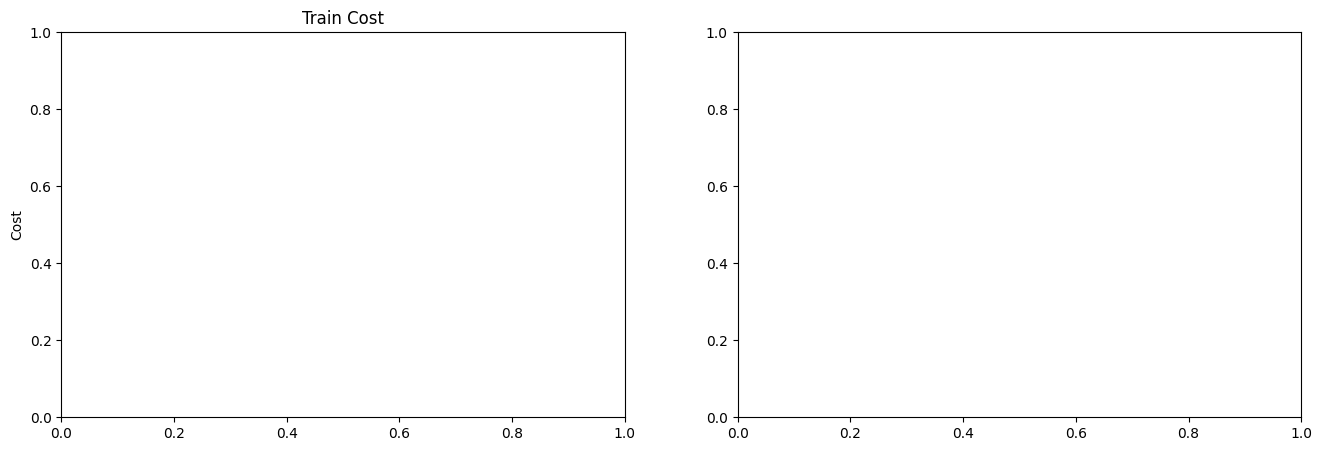

In [ ]:
plot_validation_curves(hist)